In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import timedelta

In [28]:
# loading in data
slurm = pd.read_csv("/mnt/research/CMSE495-SS24-ICER/slurm_usage/DID_FINAL_SLURM_OCT_2023.csv", delimiter="|")
slurm = slurm.drop(columns=["Unnamed: 0.1","Unnamed: 0"])
slurm.head()

JobID      User      Group               Submit                Start  \
0  31496544  user_679  group_121  2023-03-21T11:13:45              Unknown   
1  31497932  user_679  group_121  2023-03-21T11:31:18              Unknown   
2  31993628  user_105  group_114  2023-03-22T18:19:12              Unknown   
3  39087660  user_652  group_054  2023-04-04T13:09:10              Unknown   
4  59062820  user_188  group_046  2023-05-08T09:58:20  2024-01-01T00:58:57   

                   End   Elapsed      State      Account      AssocID  ...  \
0              Unknown  00:00:00    PENDING  account_017  assocID_489  ...   
1              Unknown  00:00:00    PENDING  account_017  assocID_489  ...   
2              Unknown  00:00:00    PENDING  account_017  assocID_661  ...   
3              Unknown  00:00:00    PENDING  account_017  assocID_557  ...   
4  2024-01-01T00:59:06  00:00:09  COMPLETED  account_017  assocID_676  ...   

  CPUTimeRAW ReqCPUS AllocCPUS  ReqMem MaxRSS ReqNodes  NNodes       NodeList  \
0          0      28         0  21000M    NaN        1       1  None assigned   
1          0      28         0  21000M    NaN        1       1  None assigned   
2          0      12         0    150G    NaN        1       1  None assigned   
3          0     640         0     20G    NaN       10      10  None assigned   
4        360      40        40      8G    NaN        1       1        skl-029   

                                            ReqTRES  \
0  billing=3192,cpu=28,gres/gpu=4,mem=21000M,node=1   
1  billing=3192,cpu=28,gres/gpu=4,mem=21000M,node=1   
2   billing=23347,cpu=12,gres/gpu=8,mem=150G,node=1   
3              billing=3112,cpu=640,mem=20G,node=10   
4                 billing=1245,cpu=40,mem=8G,node=1   

                           AllocTRES  
0                                NaN  
1                                NaN  
2                                NaN  
3                                NaN  
4  billing=1245,cpu=40,mem=8G,node=1  

[5 rows x 26 columns]

In [3]:
id = slurm["JobID"].value_counts().index
id

Index([95132492, 94146552, 95100872, 98058060, 92134676, 90397252, 92527020,
       98416124, 94417348, 95239856,
       ...
       94625396, 94625400, 94625404, 94625408, 94625412, 94625416, 94625420,
       94625424, 94625428, 99254124],
      dtype='int64', name='JobID', length=1433546)

In [4]:
spec_user = slurm[slurm["JobID"] == 90361456]

# spec_user["NodeList"].value_counts()

am_70 = spec_user[spec_user["NodeList"] == "amr-070"]

cpu_time_list = am_70["CPUTimeRAW"].value_counts()

cpu_time_list[cpu_time_list == 2]

CPUTimeRAW
4341040    2
783660     2
788000     2
812560     2
783220     2
815520     2
2694720    2
Name: count, dtype: int64

In [5]:
spec_user[spec_user["CPUTimeRAW"] == 815520]

JobID      User      Group               Submit                Start  \
691  90361456  user_606  group_000  2023-09-25T14:22:02  2023-09-30T22:05:41   
692  90361456  user_258  group_010  2023-09-30T22:05:41  2023-09-30T22:05:41   

                     End   Elapsed      State      Account      AssocID  ...  \
691  2023-10-01T09:25:17  11:19:36  COMPLETED  account_085  assocID_011  ...   
692  2023-10-01T09:25:17  11:19:36  COMPLETED  account_085  assocID_011  ...   

    CPUTimeRAW ReqCPUS AllocCPUS ReqMem      MaxRSS ReqNodes  NNodes  \
691     815520      20        20   160G         NaN        1       1   
692     815520      20        20    NaN  132740564K        1       1   

     NodeList                               ReqTRES  \
691   amr-070  billing=24903,cpu=20,mem=160G,node=1   
692   amr-070                                   NaN   

                                AllocTRES  
691  billing=24903,cpu=20,mem=160G,node=1  
692                cpu=20,mem=160G,node=1  

[2 rows x 26 columns]

(array([11., 21., 10.,  8.,  8.,  7.,  4.,  4.,  3.,  1.,  2.,  2.,  1.,
         0.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.]),
 array([ 1.  ,  4.08,  7.16, 10.24, 13.32, 16.4 , 19.48, 22.56, 25.64,
        28.72, 31.8 , 34.88, 37.96, 41.04, 44.12, 47.2 , 50.28, 53.36,
        56.44, 59.52, 62.6 , 65.68, 68.76, 71.84, 74.92, 78.  ]),
 <BarContainer object of 25 artists>)

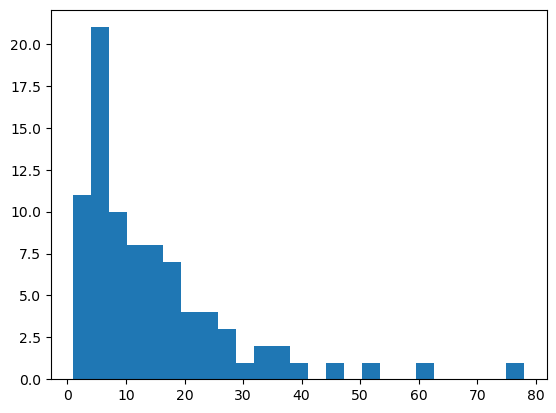

In [6]:
plt.hist(spec_user["NodeList"].value_counts().values, 25)

In [7]:
def CleanSLURMDat(dat):
    '''
    Aggregates all submitted jobs together, removing all batch/extern 
    jobs and including said information into a single job. Excludes
    jobs that do not have a clear '.batch' and '.extern' files

    args:

        dat - the slurm dataset 
    
    returns:

        out_df - the aggregated version of the slurm dataset
    '''
    
    job_list = slurm["JobID"].value_counts().index

    out_df = pd.DataFrame(columns=dat.keys())

    for job in job_list:

        jdat = dat[dat["JobID"] == job]

        cpu_time_list = jdat["CPUTimeRAW"].value_counts()
        cpu_time_list = cpu_time_list[cpu_time_list == 2].index

        for cpu_time in cpu_time_list:

            ajob = jdat[jdat["CPUTimeRAW"] == cpu_time]

            batch_job = ajob[ajob["User"] == "user_258"]

            ag_job = ajob[ajob["User"] != "user_258"]

            if len(ag_job["User"]) == 0:
                print("Weird Job",ajob["JobID"])
                print("No aggregate job")
                continue
            
            if len(ag_job["User"]) == 2:
                print("Weird Job",ajob["JobID"])
                print("2 copies of aggregate job")
                continue

            assert len(ag_job["User"]) == 1, "New edge case discovered!"

            ag_job.loc[ag_job.index[0],"MaxRSS"] = batch_job["MaxRSS"].values[0]

            out_df = pd.concat([out_df,ag_job])

    return out_df
    

In [8]:
# nslurm = slurm[slurm["State"] == "COMPLETED"]

ndf = pd.read_csv("/mnt/scratch/tairaeli/cmse_dat/clean_slurm.csv")
ndf.head()

Unnamed: 0     JobID      User      Group               Submit  \
0      336748  92134676  user_272  group_154  2023-10-02T19:49:11   
1      336736  92134676  user_272  group_154  2023-10-02T19:49:11   
2      336733  92134676  user_272  group_154  2023-10-02T19:49:11   
3      336730  92134676  user_272  group_154  2023-10-02T19:49:11   
4      336727  92134676  user_272  group_154  2023-10-02T19:49:11   

                 Start                  End   Elapsed      State      Account  \
0  2023-10-02T19:51:56  2023-10-02T23:20:44  03:28:48  COMPLETED  account_016   
1  2023-10-02T19:51:51  2023-10-02T23:34:24  03:42:33  COMPLETED  account_016   
2  2023-10-02T19:49:16  2023-10-02T23:38:41  03:49:25  COMPLETED  account_016   
3  2023-10-02T19:49:16  2023-10-02T23:40:47  03:51:31  COMPLETED  account_016   
4  2023-10-02T19:49:16  2023-10-02T23:47:02  03:57:46  COMPLETED  account_016   

   ... CPUTimeRAW ReqCPUS AllocCPUS ReqMem    MaxRSS ReqNodes NNodes  \
0  ...      12528       1         1   200G  2281632K        1      1   
1  ...      13353       1         1   200G  2323692K        1      1   
2  ...      13765       1         1   200G  2279580K        1      1   
3  ...      13891       1         1   200G  2280680K        1      1   
4  ...      14266       1         1   200G  2357408K        1      1   

   NodeList                              ReqTRES  \
0   acm-025  billing=31129,cpu=1,mem=200G,node=1   
1   amr-204  billing=31129,cpu=1,mem=200G,node=1   
2   amr-241  billing=31129,cpu=1,mem=200G,node=1   
3   amr-241  billing=31129,cpu=1,mem=200G,node=1   
4   amr-241  billing=31129,cpu=1,mem=200G,node=1   

                             AllocTRES  
0  billing=31129,cpu=1,mem=200G,node=1  
1  billing=31129,cpu=1,mem=200G,node=1  
2  billing=31129,cpu=1,mem=200G,node=1  
3  billing=31129,cpu=1,mem=200G,node=1  
4  billing=31129,cpu=1,mem=200G,node=1  

[5 rows x 27 columns]

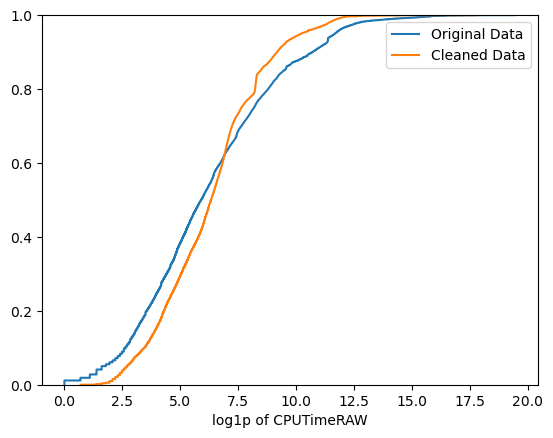

In [9]:
plt.ecdf(np.log1p(slurm["CPUTimeRAW"].astype("float")), label="Original Data")
plt.ecdf(np.log1p(ndf["CPUTimeRAW"].astype("float")), label="Cleaned Data")
plt.xlabel("log1p of CPUTimeRAW")
plt.legend()

In [10]:
# convert ReqMem to a uniform measurement (assuming 'M' for MB and 'G' for GB and 'K' for KB)
def convert_memory(mem_str):
    '''
    Convert memory units to MegaBytes unit float.
    '''
    if type(mem_str) == float:
        return np.nan
    if mem_str.endswith('M'):
        return float(mem_str[:-1]) # remove 'M' and convert to float
    elif mem_str.endswith('K'):
        return float(mem_str[:-1]) / 1000
    elif mem_str.endswith('G'):
        return float(mem_str[:-1]) * 1e3  # convert MB to KB
    elif mem_str.endswith('T'):
        return float(mem_str[:-1]) * 1e6 # convert MB to T
    elif mem_str == np.nan:
        return np.nan
    
# Function to parse time data columns: TimeLimit and Elapsed
def parse_time_string(time_str):
    """Convert a time string into a timedelta object."""
    days = 0
    
    if type(time_str) == float:
        return np.nan
    
    if '-' in time_str:
        days, time_str = time_str.split('-')
        days = int(days)

    parts = time_str.split(':')
    hours, minutes, seconds = map(int, parts) if len(parts) == 3 else (int(parts[0]), int(parts[1]), 0)
    return timedelta(days=days, hours=hours, minutes=minutes, seconds=seconds)

In [11]:
ndf1 = ndf.dropna()

In [12]:
ndf1.keys()

Index(['Unnamed: 0', 'JobID', 'User', 'Group', 'Submit', 'Start', 'End',
       'Elapsed', 'State', 'Account', 'AssocID', 'Partition', 'Timelimit',
       'UserCPU', 'SystemCPU', 'TotalCPU', 'CPUTime', 'CPUTimeRAW', 'ReqCPUS',
       'AllocCPUS', 'ReqMem', 'MaxRSS', 'ReqNodes', 'NNodes', 'NodeList',
       'ReqTRES', 'AllocTRES'],
      dtype='object')

In [13]:
# doing some numerical conversion
def conv_to_num(df):
    ndf = df.copy()
    ndf.loc[:,"Elapsed"] = df["Elapsed"].apply(parse_time_string)
    ndf.loc[:,"Timelimit"] = df["Timelimit"].apply(parse_time_string)
    ndf.loc[:,"MaxRSS"] = df["MaxRSS"].apply(convert_memory)
    ndf.loc[:,"ReqMem"] = df["ReqMem"].apply(convert_memory)
    ndf.loc[:,"CPUTime"] = df["CPUTime"].apply(parse_time_string)

    return ndf

ndf = conv_to_num(ndf.dropna())
slurm = conv_to_num(slurm)
# ndf1["Elapsed"] = ndf1["Elapsed"].apply(parse_time_string)
# ndf1["Timelimit"] = ndf1["Timelimit"].apply(parse_time_string)
# ndf1["MaxRSS"] = ndf1["MaxRSS"].apply(convert_memory)
# ndf1["CPUTime"] = ndf1["CPUTime"].apply(parse_time_string)
# ndf1.keys()

In [14]:
ndf.head()

Unnamed: 0     JobID      User      Group               Submit  \
0      336748  92134676  user_272  group_154  2023-10-02T19:49:11   
1      336736  92134676  user_272  group_154  2023-10-02T19:49:11   
2      336733  92134676  user_272  group_154  2023-10-02T19:49:11   
3      336730  92134676  user_272  group_154  2023-10-02T19:49:11   
4      336727  92134676  user_272  group_154  2023-10-02T19:49:11   

                 Start                  End          Elapsed      State  \
0  2023-10-02T19:51:56  2023-10-02T23:20:44  0 days 03:28:48  COMPLETED   
1  2023-10-02T19:51:51  2023-10-02T23:34:24  0 days 03:42:33  COMPLETED   
2  2023-10-02T19:49:16  2023-10-02T23:38:41  0 days 03:49:25  COMPLETED   
3  2023-10-02T19:49:16  2023-10-02T23:40:47  0 days 03:51:31  COMPLETED   
4  2023-10-02T19:49:16  2023-10-02T23:47:02  0 days 03:57:46  COMPLETED   

       Account  ... CPUTimeRAW ReqCPUS AllocCPUS    ReqMem    MaxRSS ReqNodes  \
0  account_016  ...      12528       1         1  200000.0  2281.632        1   
1  account_016  ...      13353       1         1  200000.0  2323.692        1   
2  account_016  ...      13765       1         1  200000.0   2279.58        1   
3  account_016  ...      13891       1         1  200000.0   2280.68        1   
4  account_016  ...      14266       1         1  200000.0  2357.408        1   

  NNodes  NodeList                              ReqTRES  \
0      1   acm-025  billing=31129,cpu=1,mem=200G,node=1   
1      1   amr-204  billing=31129,cpu=1,mem=200G,node=1   
2      1   amr-241  billing=31129,cpu=1,mem=200G,node=1   
3      1   amr-241  billing=31129,cpu=1,mem=200G,node=1   
4      1   amr-241  billing=31129,cpu=1,mem=200G,node=1   

                             AllocTRES  
0  billing=31129,cpu=1,mem=200G,node=1  
1  billing=31129,cpu=1,mem=200G,node=1  
2  billing=31129,cpu=1,mem=200G,node=1  
3  billing=31129,cpu=1,mem=200G,node=1  
4  billing=31129,cpu=1,mem=200G,node=1  

[5 rows x 27 columns]

In [17]:
def gen_compare_plot(feature, out_dir):
    plt.ecdf(np.log1p(slurm[feature].astype("float").dropna()), label="Original Data")
    plt.ecdf(np.log1p(ndf[feature].astype("float")), label="Cleaned Data")
    plt.xlabel(f"log1p of {feature}")
    plt.legend()
    plt.savefig(out_dir+"clean_compare_"+feature)
    plt.show()

Making plot for: CPUTimeRAW


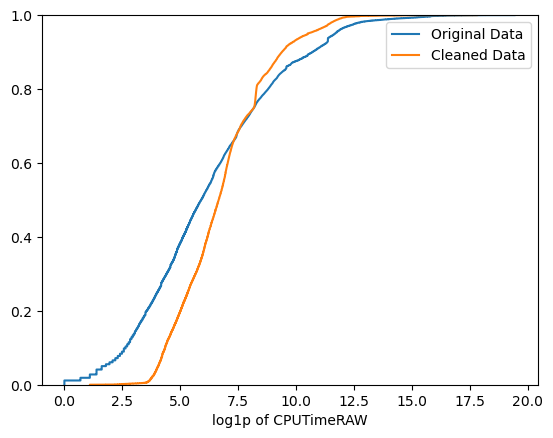

Making plot for: ReqCPUS


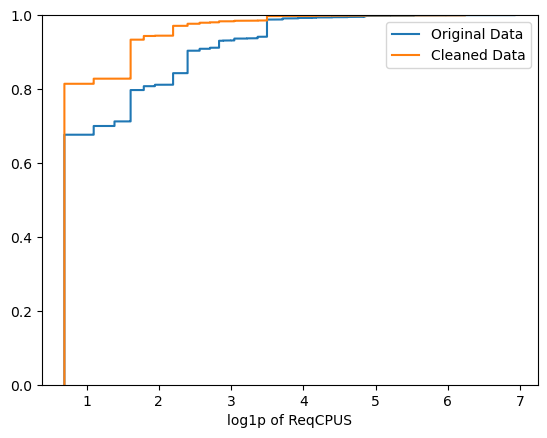

Making plot for: AllocCPUS


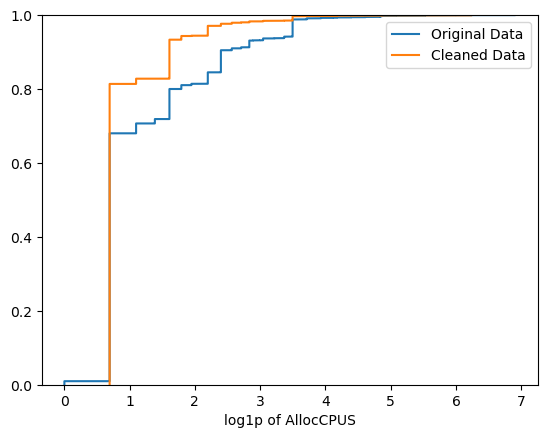

Making plot for: ReqNodes


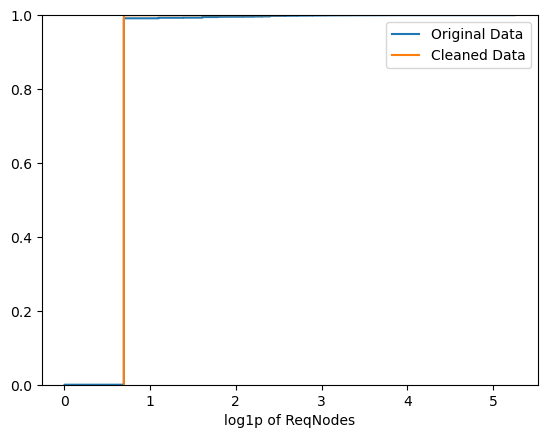

Making plot for: NNodes


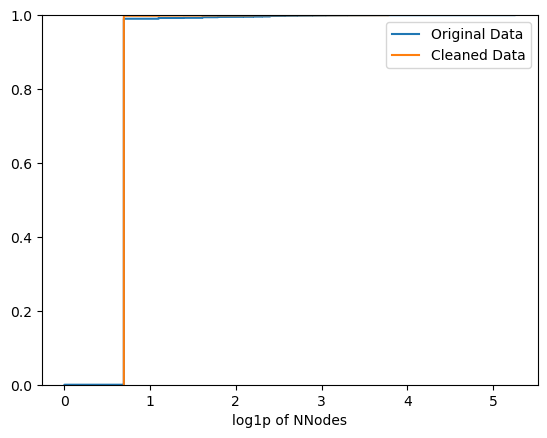

Making plot for: MaxRSS


ValueError: ecdf() does not support NaNs

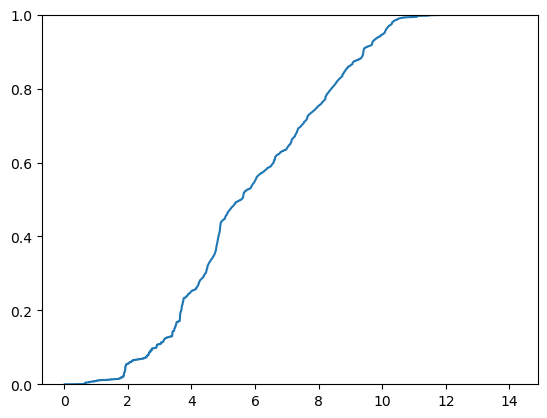

In [18]:
out_dir = "/mnt/scratch/tairaeli/cmse_dat/"

num_keys = ['CPUTimeRAW','ReqCPUS', 'AllocCPUS', 'ReqNodes', 'NNodes',]

for key in num_keys:
    print("Making plot for:",key)
    gen_compare_plot(key, out_dir)

In [49]:
slurm[['CPUTimeRAW', 'ReqCPUS', 'AllocCPUS', 'ReqMem',
       'MaxRSS', 'ReqNodes', 'NNodes']]

Index(['JobID', 'User', 'Group', 'Submit', 'Start', 'End', 'Elapsed', 'State',
       'Account', 'AssocID', 'Partition', 'Timelimit', 'UserCPU', 'SystemCPU',
       'TotalCPU', 'CPUTime', 'CPUTimeRAW', 'ReqCPUS', 'AllocCPUS', 'ReqMem',
       'MaxRSS', 'ReqNodes', 'NNodes', 'NodeList', 'ReqTRES', 'AllocTRES'],
      dtype='object')

In [55]:
slurm["NNodes"]

0         1
1         1
2         1
3        10
4         1
         ..
99995     1
99996     1
99997     1
99998     1
99999     1
Name: NNodes, Length: 100000, dtype: int64